In [1]:
import torch
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
from bs4 import BeautifulSoup
from PIL import Image
from matplotlib import patches
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# load data

### 因為xml檔案讀取後是 object ，所以需要用 beautifulSoup 套件轉成 text
### 需要轉換的項目有 boxes , label
### 最後將其輸出成已經是 tensor 的 dic
### The dtype of labels in detection model shoud be int64  

In [2]:
def get_box(obj):
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    return [xmin,ymin,xmax,ymax]

def get_label(obj):
    if obj.find('name').text =='with_mask' :
        return 1 
    elif obj.find('name').text =='without_mask':
        return 2 
    return 0

In [3]:
def obj_to_target(image_id , file):
    with open (file) as f:
        data = f.read()
        soup = BeautifulSoup(data,'xml')
        objects = soup.find_all('object')
        obj_len = len(objects)
        boxes = []
        labels = []
        for i in objects:
            boxes.append(get_box(i))
            labels.append(get_label(i))

        boxes = torch.as_tensor(boxes,dtype = torch.float32)
        
        labels = torch.as_tensor(labels,dtype = torch.int64) 
        image_id = torch.as_tensor([image_id],dtype = torch.float32)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id

        return target

In [4]:
imgs = list(sorted(os.listdir("images/")))
labels = list(sorted(os.listdir("annotations/")))

### Create DataSet

In [5]:
class MaskDataset(object):
    def __init__(self,trasforms):
        self.trasforms = trasforms
        self.imgs = list(sorted(os.listdir("images/")))
    
    def __getitem__(self,idx):
        file_image = "maksssksksss" + str(idx) + ".png"
        file_labels = "maksssksksss" + str(idx) + ".xml"
        image_path = os.path.join("images/",file_image)
        label_path = os.path.join("annotations/",file_labels)
        img = Image.open(image_path).convert('RGB')
        target = obj_to_target(idx, label_path)

        if self.trasforms != None:
            img = self.trasforms(img)
        return img , target

    def __len__(self):
        return len(self.imgs)

In [6]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])
def collate_size(batch):
    return tuple(zip(*batch))

In [7]:
dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(dataset,batch_size=4,collate_fn=collate_size)

# model

In [8]:
def get_model(num):
    # get pretrain model 
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained= True)
    # set new feature layers
    in_feature = model.roi_heads.box_predictor.cls_score.in_features
    # replace the new layer with parameter
    model.roi_heads.box_predictor  = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_feature, num_classes=num)
    return model

    
# none - withmask - withoutmask
model = get_model(3)

In [10]:
EPOCHS = 50
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params,lr= 5e-3 , momentum=9e-1 , weight_decay= 5e-4)
len_loader = len(data_loader)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    i = 0 
    for imgs , annotations in data_loader:
        i+=1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k,v in t.items()} for t in annotations]

        loss_dict = model([imgs[0]],[annotations[0]])
        losses = sum(loss for loss  in  loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses
        #print(losses)
    print("EPOCHS:{}  LOSS:{}".format(epoch,epoch_loss))

EPOCHS:0  LOSS:75.2225341796875
EPOCHS:1  LOSS:62.20501708984375
EPOCHS:2  LOSS:52.863094329833984
EPOCHS:3  LOSS:42.18647766113281
EPOCHS:4  LOSS:39.41168975830078
EPOCHS:5  LOSS:36.258853912353516
EPOCHS:6  LOSS:34.88839340209961
EPOCHS:7  LOSS:34.32380676269531
EPOCHS:8  LOSS:34.67509460449219
EPOCHS:9  LOSS:30.84820556640625
EPOCHS:10  LOSS:29.999479293823242
EPOCHS:11  LOSS:28.575380325317383
EPOCHS:12  LOSS:28.038957595825195
EPOCHS:13  LOSS:28.956459045410156
EPOCHS:14  LOSS:27.612422943115234
EPOCHS:15  LOSS:25.183340072631836
EPOCHS:16  LOSS:26.732450485229492
EPOCHS:17  LOSS:25.95669937133789
EPOCHS:18  LOSS:23.627683639526367
EPOCHS:19  LOSS:22.590290069580078
EPOCHS:20  LOSS:24.676746368408203
EPOCHS:21  LOSS:20.787858963012695
EPOCHS:22  LOSS:20.085939407348633
EPOCHS:23  LOSS:22.406620025634766
EPOCHS:24  LOSS:22.4732723236084
EPOCHS:25  LOSS:23.509784698486328
EPOCHS:26  LOSS:23.369844436645508
EPOCHS:27  LOSS:19.5292911529541
EPOCHS:28  LOSS:19.734357833862305
EPOCHS:29

In [11]:
torch.save(model,"mdoel_0720.pth")
torch.save(model.state_dict(),"mdoel_state_0720.pth")

In [8]:
model = torch.load('mdoel_0720.pth')

In [9]:
for imgs , annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k,v in t.items()} for t in annotations]
    break

In [10]:
model.eval()
pred = model([imgs[0]])

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\ops\boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


In [35]:
def detection_plot (img_tensor): 
    for image in img_tensor:
        pred = model([image])
        fig , ax = plt.subplots(1)
        fig.set_figheight(10)
        fig.set_figwidth(10)
        ax.imshow(np.moveaxis(image.cpu().detach().numpy(),0,-1))

        for num in range(len(pred)):
            boxes = pred[num]['boxes'].cpu().detach().numpy()
            labels = list(pred[num]['labels'].cpu().detach().numpy())
            scores = pred[num]['scores'].cpu().detach().numpy()
            labels = [ 'No Mask' if i == 2 else 'Mask' for i in labels]
            for idx in range(len(boxes)):
                if labels[idx]=='Mask' and scores[idx]>0.8:
                    draw_box = patches.Rectangle((boxes[idx][0],boxes[idx][1]),(boxes[idx][2]-boxes[idx][0]),(boxes[idx][3]-boxes[idx][1]),color = 'lime' ,fill = False, linewidth = 2.5 ,label = labels[idx],linestyle = '--')
                    ax.add_patch(draw_box)
                    ax.annotate(str(labels[idx]),(int(boxes[idx][0]),int(boxes[idx][1])-10),color = 'lime' , fontsize = 15)
                    ax.annotate(str(int(scores[idx]*100))+" %",(int(boxes[idx][0]),int(boxes[idx][1])-25),color = 'lime' , fontsize = 15)
                elif labels[idx]=='No Mask' and scores[idx]>0.8:     
                    draw_box = patches.Rectangle((boxes[idx][0],boxes[idx][1]),(boxes[idx][2]-boxes[idx][0]),(boxes[idx][3]-boxes[idx][1]),color = 'red' ,fill = False, linewidth = 2.5 ,label = labels[idx],linestyle = '--')
                    ax.add_patch(draw_box)
                    ax.annotate(str(labels[idx]),(int(boxes[idx][0]),int(boxes[idx][1])-10),color = 'red' , fontsize = 15)
                    ax.annotate(str(int(scores[idx]*100))+" %",(int(boxes[idx][0]),int(boxes[idx][1])-25),color = 'red' , fontsize = 15 , )
    plt.show()

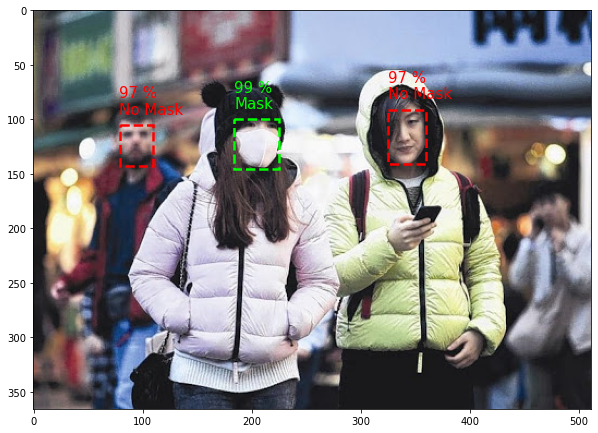

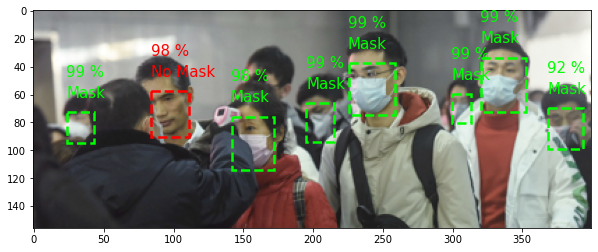

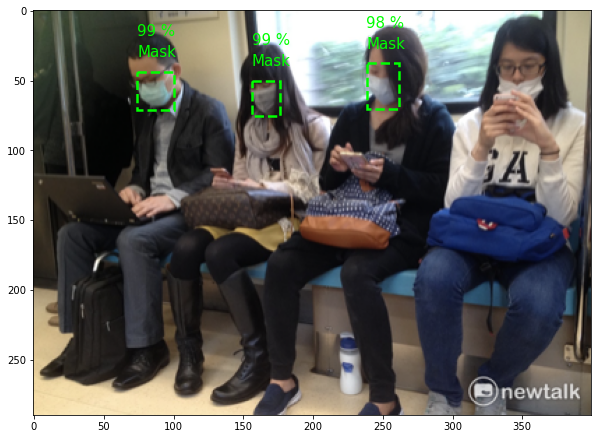

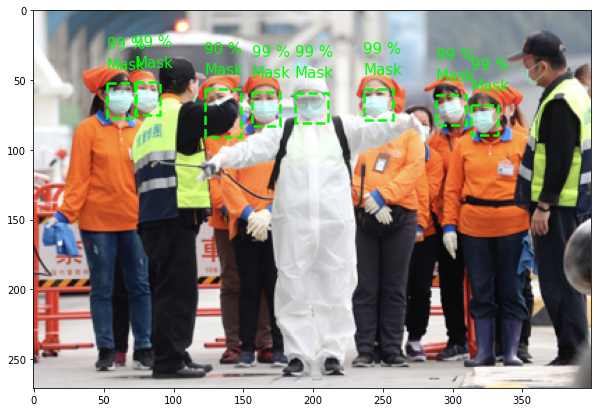

In [36]:
detection_plot(imgs)